In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

In [2]:
old = np.load('/Users/nix/downloads/2021.npy')
new = np.load('/Users/nix/downloads/2022.npy')

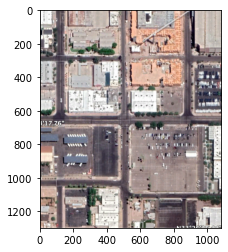

In [3]:
plt.imshow(old[0, :, :, :])
plt.show()

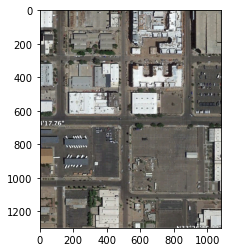

In [4]:
plt.imshow(new[0, :, :, :])
plt.show()

In [5]:
diff_one = new[0, :, :, :] - old[0, :, :, :]
mask = diff_one + np.array([0,0,0,255])


In [124]:
new[0, :, :, :].shape

(1298, 1082, 4)

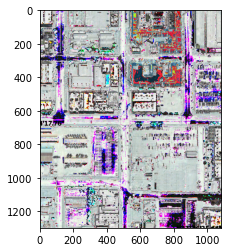

In [6]:
plt.imshow(mask)
plt.show()

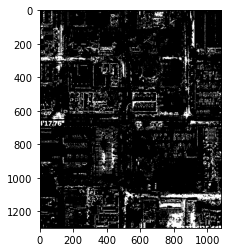

In [7]:
hsv_color1 = np.asarray([0,0,0,255])   # white!
hsv_color2 = np.asarray([138,43,226,255])   # yellow! note the order

output = cv2.inRange(mask, hsv_color1, hsv_color2)

plt.imshow(output, cmap='gray')   # this colormap will display in black / white
plt.show()

In [8]:
new_matrix = new[0, :, :, :]
old_matrix = old[0, :, :, :]

for i in range(output.shape[0]):
    for j in range(output.shape[1]):
        if output[i][j] == 0:
            new_matrix[i][j] = [0,0,0,0]
            old_matrix[i][j] = [0,0,0,0]

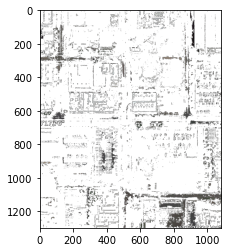

In [9]:
plt.imshow(new_matrix)
plt.show()

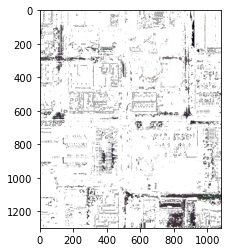

In [10]:
plt.imshow(old_matrix)
plt.show()

In [11]:
def preprocess(inputs, old, new):
    
    processed_new = {}
    processed_old = {}
    for input in inputs:
        old_matrix = old[input, :, :, :]
        new_matrix = new[input, :, :, :]
        diff = new_matrix - old_matrix
        mask = diff + np.array([0,0,0,255])
        
        hsv_color1 = np.asarray([0,0,0,255])   
        hsv_color2 = np.asarray([138,43,226,255])   
        output = cv2.inRange(mask, hsv_color1, hsv_color2)
        
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                if output[i][j] == 0:
                    new_matrix[i][j] = [0,0,0,0]
                    old_matrix[i][j] = [0,0,0,0]
        
        processed_new[input] = new_matrix
        processed_old[input] = old_matrix
        
    return processed_new, processed_old

In [12]:
inputs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
processed_new, processed_old = preprocess(inputs, old, new)

In [13]:
processed_new[0].shape

(1298, 1082, 4)

## Create and Train Model

In [14]:
from PIL import Image
for i in range(20):
    new_im = Image.fromarray(processed_new[i])
    old_im = Image.fromarray(processed_old[i])
    new_im = new_im.save(f"/Users/nix/desktop/train/new/{i}.png")
    old_im = old_im.save(f"/Users/nix/desktop/train/old/{i}.png")

In [125]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim


In [131]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.pool1 = nn.MaxPool2d(kernel_size=7, stride=3)
        self.pool2 = nn.MaxPool2d(kernel_size=7, stride=3)
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 4, kernel_size=3, stride=2)
        self.fc1 = nn.Linear(in_features = 3808, out_features = 952)
        self.fc2 = nn.Linear(in_features = 952, out_features = 238)
        self.fc3 = nn.Linear(in_features = 238, out_features = 40)
        self.fc4 = nn.Linear(in_features = 40, out_features = 2)
        
    def forward(self, x):
        x = self.pool1(x)
        x = self.pool2(x)
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = x.view(-1, 3808)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        return x

In [132]:
cnn = CNN()

In [133]:
print(cnn)

CNN(
  (pool1): MaxPool2d(kernel_size=7, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=7, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(6, 4, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=3808, out_features=952, bias=True)
  (fc2): Linear(in_features=952, out_features=238, bias=True)
  (fc3): Linear(in_features=238, out_features=40, bias=True)
  (fc4): Linear(in_features=40, out_features=2, bias=True)
)


In [134]:
def get_data():
    data_dir = '/Users/nix/desktop/train'
    
    transform = transforms.Compose([transforms.ToTensor()])

    train_set = datasets.ImageFolder(data_dir, transform=transform)
    #train_set = datasets.ImageFolder(data_dir)
    
    train = DataLoader(train_set, batch_size=1, shuffle=True)
    

    return train

40it [00:02, 15.86it/s]
40it [00:02, 19.63it/s]
40it [00:01, 21.12it/s]
40it [00:01, 20.79it/s]
40it [00:01, 21.03it/s]
40it [00:01, 21.08it/s]
40it [00:01, 21.20it/s]
40it [00:01, 21.15it/s]
40it [00:01, 21.21it/s]
40it [00:01, 21.08it/s]
40it [00:01, 20.88it/s]
40it [00:01, 21.06it/s]
40it [00:01, 20.94it/s]
40it [00:01, 21.01it/s]
40it [00:01, 20.97it/s]
40it [00:01, 20.54it/s]
40it [00:01, 20.57it/s]
40it [00:02, 18.58it/s]
40it [00:01, 20.05it/s]
40it [00:01, 20.42it/s]
40it [00:02, 19.05it/s]
40it [00:02, 17.73it/s]
40it [00:02, 18.39it/s]
40it [00:02, 19.49it/s]
40it [00:01, 20.21it/s]
40it [00:01, 20.50it/s]
40it [00:01, 20.52it/s]
40it [00:01, 20.86it/s]
40it [00:01, 20.97it/s]
40it [00:01, 21.07it/s]
40it [00:01, 21.02it/s]
40it [00:01, 21.14it/s]
40it [00:01, 20.57it/s]
40it [00:01, 21.02it/s]
40it [00:01, 21.09it/s]
40it [00:01, 20.21it/s]
40it [00:01, 20.89it/s]
40it [00:01, 20.92it/s]
40it [00:01, 20.78it/s]
40it [00:01, 20.52it/s]
40it [00:01, 20.41it/s]
40it [00:01, 20.

40it [00:01, 20.18it/s]
40it [00:01, 20.02it/s]
40it [00:02, 19.76it/s]
40it [00:01, 20.22it/s]
40it [00:01, 20.43it/s]
40it [00:01, 20.12it/s]
40it [00:01, 20.40it/s]
40it [00:02, 19.65it/s]
40it [00:01, 20.58it/s]
40it [00:01, 20.29it/s]
40it [00:01, 20.40it/s]
40it [00:01, 20.18it/s]
40it [00:01, 20.20it/s]
40it [00:02, 19.95it/s]
40it [00:01, 20.19it/s]
40it [00:02, 17.35it/s]
40it [00:02, 19.96it/s]
40it [00:02, 19.71it/s]
40it [00:02, 19.98it/s]
40it [00:02, 19.95it/s]
40it [00:02, 19.59it/s]
40it [00:02, 19.98it/s]
40it [00:02, 19.86it/s]
40it [00:02, 19.90it/s]
40it [00:01, 20.06it/s]
40it [00:02, 19.96it/s]
40it [00:01, 20.03it/s]
40it [00:01, 20.15it/s]
40it [00:02, 19.98it/s]
40it [00:01, 20.54it/s]
40it [00:02, 18.96it/s]
40it [00:01, 20.35it/s]
40it [00:01, 20.35it/s]
40it [00:01, 20.38it/s]
40it [00:01, 20.22it/s]
40it [00:01, 20.53it/s]
40it [00:01, 20.43it/s]
40it [00:01, 20.65it/s]
40it [00:01, 20.49it/s]
40it [00:01, 20.44it/s]
40it [00:01, 20.29it/s]
40it [00:02, 19.

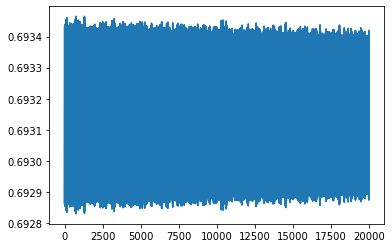

Finished Training


In [141]:
from tqdm import tqdm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)
if torch.cuda.is_available(): # Checking if we can use GPU
    model = cnn.cuda()
    criterion = criterion.cuda()


def train_net(n_epoch, train): # Training our network
    losses = []
    for epoch in range(n_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in tqdm(enumerate(train, 0)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            losses.append(loss)
            running_loss += loss.item()
            if i % 100 == 99:  # print every 2000 mini-batches
                print('[%d, %5d] loss: %.10f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    plt.plot(losses, label='Training loss')
    plt.show()
    print('Finished Training')
train_net(500, get_data())   

In [142]:
correct = 0
total = 0
train = get_data()
with torch.no_grad():
    for data in train:
        images, labels = data
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (len(train),
    100 * correct / total))

Accuracy of the network on the 40 test images: 50 %
